In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(cowplot))

## For loading Arial font for publication
# library(extrafont)

# font_import(pattern = "Arial", prompt = FALSE)
# loadfonts(device = "pdf")

In [2]:
master_csv <- "resources/AF_master.csv"
master_df <- read.csv(file = master_csv, header = TRUE, stringsAsFactors = FALSE)

# Replace "-" with 0 in the EUR_Iceland column
master_df$EUR_Iceland <- ifelse(master_df$EUR_Iceland == "-", 0, master_df$EUR_Iceland)

In [3]:
head(master_df)

,Gene,MOI,HKGI_AF,Related_Disease,CHI_HKGP,KOR_Korea,MID_Qatar,EUR_Iceland,EUR_UK100K,EUR_AoU,AFR_AoU,AMR_AoU,ClinVar_PLP,ClinVar_VUS,Novel,Novel_SNV,Novel_Indel
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,SCN5A,AD,,Cardiovascular,0.004709490,0.000669165,0.000486381,0.00010,-,0.000422807,0.000873477,0.000314604,1,8,2,2,0
2,TTN,AD,,Cardiovascular,0.004490444,0.006557816,0.006670372,0.00117,-,NA,0.000000000,NA,22,9,42,42,0
3,LDLR,AD,Y,Cardiovascular,0.004052352,0.001605996,0.002084491,0.00140,0.002035594,0.002033502,0.002882474,0.001510099,16,6,1,0,0
4,DSG2,AD,,Cardiovascular,0.002354745,0.000936831,0.000208449,0.00009,-,NA,0.000000000,NA,1,2,2,2,0
5,APOB,AD,Y,Cardiovascular,0.002135699,0.001338330,0.000694830,0.00005,0.000639758,0.001147620,0.000174695,0.000566287,2,1,7,7,0
6,PKP2,AD,,Cardiovascular,0.000985707,0.000401499,0.000208449,0.00238,-,0.000402674,0.001441237,0.000377525,6,0,4,3,1


In [4]:
var_df <- master_df %>%
    select(Gene, Related_Disease, ClinVar_PLP, ClinVar_VUS, Novel)

# Sort var_df by all_var
var_df$all_var <- var_df$ClinVar_PLP + var_df$ClinVar_VUS + var_df$Novel
var_df <- var_df %>%
    arrange(Related_Disease, desc(all_var)) %>% 
    filter(all_var > 0)

var_df$Related_Disease <- factor(
    var_df$Related_Disease, 
    levels = c("Cardiovascular", "Cancer", "Metabolic", "Miscellaneous")
)
var_df$Gene <- factor(var_df$Gene, levels = var_df$Gene)

In [5]:
var_tsv <- "resources/AF_variants.tsv"
var_type_df <- read.csv(file = var_tsv, sep = '\t', header = TRUE, stringsAsFactors = FALSE)

# Map Consequence_Class 
var_type_df$Consequence_Class <- gsub("missense", "Missense", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("splice_donor", "Splice", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("splice_region", "Splice", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("stop_gained", "Stop-gain", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("frameshift", "Stop-gain", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("splice_acceptor", "Splice", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("start_lost", "Stop-gain", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("inframe_deletion", "In-frame indel", var_type_df$Consequence_Class)
var_type_df$Consequence_Class <- gsub("Complex", "Complex rearrangement", var_type_df$Consequence_Class)

print(table(var_type_df$Consequence_Class))

# Concatenate Gene and Consequence_Class
var_type_df$Gene_Consequence <- paste(var_type_df$Gene, var_type_df$Consequence_Class, sep = "_")

# Group var_type_df by Gene_Consequence and count occurrences
var_type_grouped <- var_type_df %>%
  group_by(Gene_Consequence) %>%
  summarise(Count = n(), .groups = 'drop')

# Break Gene Consequence into separate columns
var_type_grouped <- var_type_grouped %>%
  separate(Gene_Consequence, into = c("Gene", "Consequence_Class"), sep = "_")

  # Treat Gene and Consequence_Class as factors
var_type_grouped$Gene <- factor(var_type_grouped$Gene, levels = var_df$Gene)
var_type_grouped$Consequence_Class <- factor(var_type_grouped$Consequence_Class, levels = c(
  "Stop-gain", "Missense", "Splice", "In-frame indel", "Deletion", "Duplication", "Complex rearrangement"
))

# Sort by Gene and Consequence_Class
var_type_grouped <- var_type_grouped %>%
  arrange(Gene, Consequence_Class)


Complex rearrangement              Deletion           Duplication 
                    1                    10                     1 
       In-frame indel              Missense                Splice 
                    1                   123                    35 
            Stop-gain 
                  206 


In [6]:
var_consequences <- table(var_type_grouped$Consequence_Class)
print(var_consequences)


            Stop-gain              Missense                Splice 
                   28                    38                    23 
       In-frame indel              Deletion           Duplication 
                    1                     5                     1 
Complex rearrangement 
                    1 


# Plot the GCF

In [7]:
# Load data and filter for genes with CHI_HKGP > 0
gcf_df <- master_df %>% 
    filter(CHI_HKGP > 0) %>%
    select(Gene, MOI, Related_Disease, CHI_HKGP)

# Get the gene ordering from var_df (which is used by var_type_grouped)
gene_order <- var_df$Gene

# Set factor levels to match the variant type plot ordering
gcf_df$Gene <- factor(gcf_df$Gene, levels = gene_order)
gcf_df$Related_Disease <- factor(gcf_df$Related_Disease, levels = c("Cardiovascular", "Cancer", "Metabolic", "Miscellaneous"))

In [8]:
disease_counts <- table(gcf_df$Related_Disease)
print(disease_counts)


Cardiovascular         Cancer      Metabolic  Miscellaneous 
            26             21              1              5 


In [9]:
# Define custom colors for Disease categories
custom_colors_disease <- c(
  "Cancer" = "#4BACC6", 
  "Cardiovascular" = "#F79646", 
  "Metabolic" = "#8064A2", 
  "Miscellaneous" = "#B65708"
)

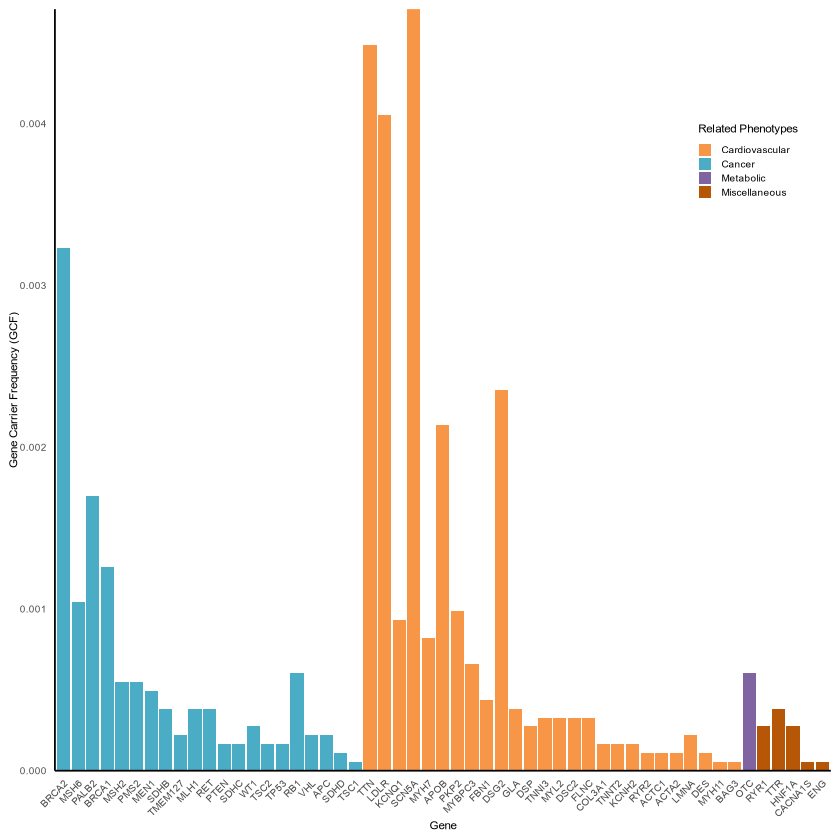

In [10]:
p <- ggplot(gcf_df, aes(x = Gene, y = CHI_HKGP, fill = Related_Disease)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_minimal() + 
  scale_fill_manual(values = custom_colors_disease) + 
  labs(
    y = "Gene Carrier Frequency (GCF)",
    fill = "Related Phenotypes"
  ) + 
  scale_y_continuous(
      expand = c(0, 0)  # Remove space at the bottom of the y-axis
  ) + 
  # theme_minimal(base_family = "Arial") + 
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 6),  # Former x-axis text, now on y-axis
    axis.text.x = element_text(angle = 45, size = 6, hjust = 1),  # Former y-axis text, now on x-axis
    plot.title = element_blank(),
    axis.title.y = element_text(size = 7),  # Former x-axis title
    axis.title.x = element_text(size = 7),  # Former y-axis title
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"), 
    legend.title = element_text(size = 7),
    legend.text = element_text(size = 6),
    legend.key.size = unit(0.3, "cm"),  # Reduce legend key size
    legend.position.inside = c(.9, .8),  # Position the legend
    legend.position = "inside"
  )


p

# # Save the combined plot
# ggsave(
#         filename = "results/secondary/dominant/main/GCF_af.pdf", 
#         plot = p, 
#         width = 168, height = 56, 
#         units = "mm", dpi = 600
#     )

# CGCF fo diseases comparing with other populations

In [11]:
cGCF_df <- master_df %>% 
    select(Gene, Related_Disease, CHI_HKGP, KOR_Korea, EUR_Iceland, AFR_AoU) %>% 
    mutate(across(where(is.numeric), ~replace_na(., 0)))

cGCF_df$Related_Disease <- factor(
    cGCF_df$Related_Disease, 
    levels = c("Cardiovascular", "Cancer", "Metabolic", "Miscellaneous")
)

cGCF_grouped <- cGCF_df %>%
  group_by(Related_Disease) %>%
  summarise(across(where(is.numeric), \(x) sum(x, na.rm = FALSE)))

# Reshape cGCF_grouped to long format for plotting
cGCF_long <- cGCF_grouped %>%
  pivot_longer(
    cols = -Related_Disease, 
    names_to = "Population", 
    values_to = "Value"
  )

cGCF_long$Related_Disease <- factor(cGCF_long$Related_Disease, levels = rev(c(
  "Cardiovascular", "Cancer", "Metabolic", "Miscellaneous"
)))

cGCF_long$Population <- factor(cGCF_long$Population, levels = c(
  "CHI_HKGP", "KOR_Korea", "EUR_Iceland", "AFR_AoU"
))

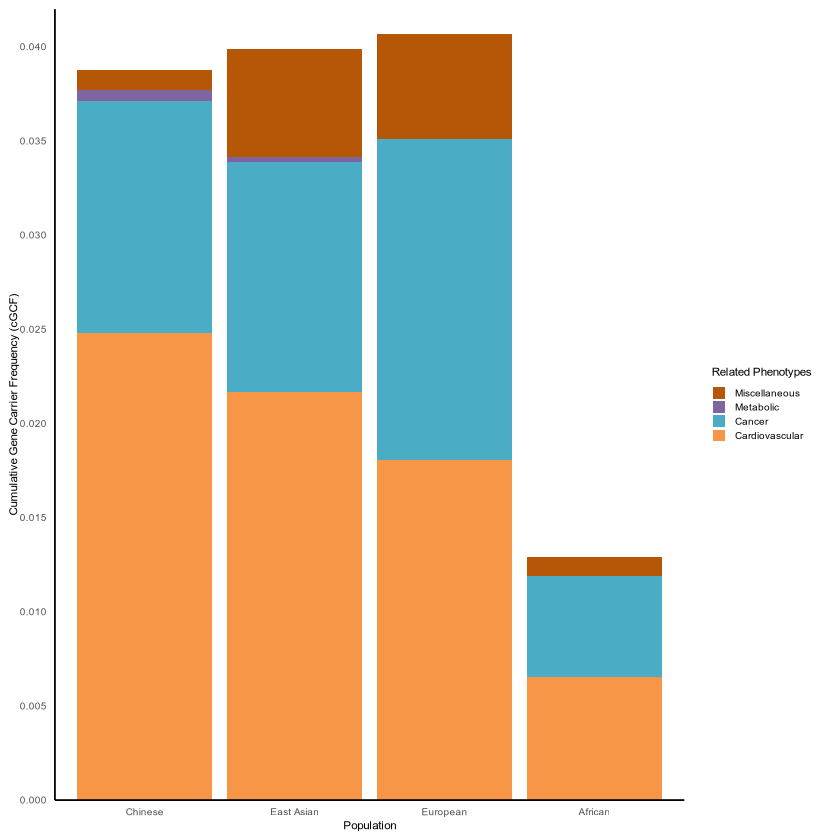

In [12]:
# Plot the stacked bar chart
stacked_bar_plot <- ggplot(cGCF_long, aes(x = Population, y = Value, fill = Related_Disease)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = custom_colors_disease) + 
  labs(
    title = "Stacked Bar Chart of Populations by Related Disease",
    x = "Population",
    y = "Cumulative Gene Carrier Frequency (cGCF)",
    fill = "Related Phenotypes"
  ) + 
  scale_x_discrete(
    labels = c(
      "CHI_HKGP" = "Chinese",
      "KOR_Korea" = "East Asian",
      "EUR_Iceland" = "European",
      "AFR_AoU" = "African"
    )
  ) + 
  scale_y_continuous(
    breaks = seq(0, .042, by = 0.005),  # Set y-axis ticks at 5% intervals
    limits = c(0, .042), 
    expand = c(0, 0)  # Remove space at the bottom of the y-axis
  ) + 
  # theme_minimal(base_family = "Arial") + 
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 6),
    axis.text.y = element_text(size = 6),
    # plot.title = element_text(size = 16, hjust = 0.5), 
    plot.title = element_blank(),
    axis.title.x = element_text(size = 7), 
    axis.title.y = element_text(size = 7), 
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"), 
    # legend.position = c(.9, .8), 
    legend.title = element_text(size = 7), 
    legend.text = element_text(size = 6),
    legend.key.size = unit(0.3, "cm")  # Reduce legend key size
  )

# Display the plot
stacked_bar_plot

# ggsave(
#     filename = "results/secondary/dominant/main/cGCF_af.pdf", 
#     plot = stacked_bar_plot, 
#     width = 90, height = 60, 
#     units = "mm", dpi = 600
# )

# Variant source breakdown by genes

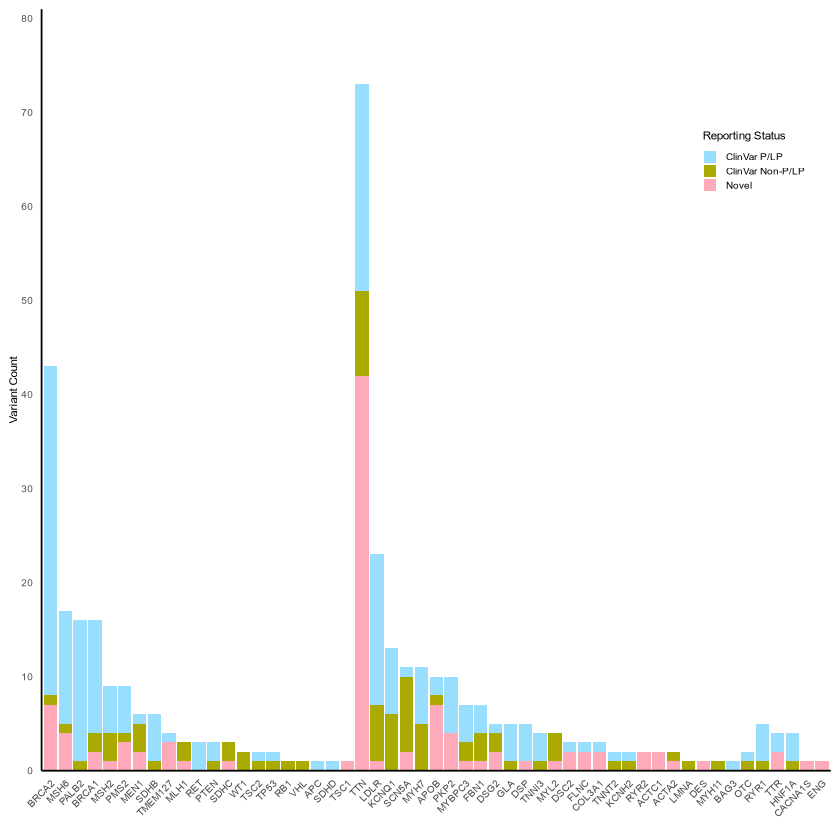

In [13]:
# Reshape var_df to long format for plotting
var_long <- var_df %>%
  pivot_longer(
    cols = c(ClinVar_PLP, ClinVar_VUS, Novel),
    names_to = "Variant_Type",
    values_to = "Value"
  )

# Plot the stacked bar chart
variant_stacked_bar <- ggplot(var_long, aes(x = Gene, y = Value, fill = Variant_Type)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(
    title = "Variants' reporting status by genes",
    x = "",
    y = "Variant Count",
    fill = "Reporting Status"
  ) + 
  scale_y_continuous(
    breaks = seq(0, 81, by = 10),  # Set y-axis ticks at 5% intervals
    limits = c(0, 81), 
    expand = c(0, 0)  # Remove space at the bottom of the y-axis
  ) + 
  # theme_minimal(base_family = "Arial") + 
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 6),  # Former x-axis text, now on y-axis
    axis.text.x = element_text(angle = 45, size = 6, hjust = 1),  # Former y-axis text, now on x-axis
    plot.title = element_blank(),
    axis.title.y = element_text(size = 7),  # Former x-axis title
    axis.title.x = element_text(size = 7),  # Former y-axis title
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"), 
    legend.title = element_text(size = 7),
    legend.text = element_text(size = 6),
    legend.key.size = unit(0.3, "cm"),  # Reduce legend key size
    legend.position.inside = c(.9, .8),  # Position the legend
    legend.position = "inside",
    # legend.title = element_text(size = 6, family = "Arial"),
    # legend.text = element_text(size = 5, family = "Arial"),
    # plot.margin = margin(0, 0, 0, 0, unit = "pt"),
  ) +
  scale_fill_manual(
    labels = c(
      "ClinVar_PLP" = "ClinVar P/LP",
      "ClinVar_VUS" = "ClinVar Non-P/LP",
      "Novel" = "Novel"
    ), 
    values = c(
      "ClinVar_PLP" = "#99DDFF",
      "ClinVar_VUS" = "#AAAA00",
      "Novel" = "#FEAABA"
    )
  )

# Display the plot
variant_stacked_bar

# # Save the plot
# ggsave(
#   filename = "results/secondary/dominant/supplementary/variant_classifications.pdf",
#   plot = variant_stacked_bar,
#   width = 176, height = 75, 
#   units = "mm", dpi = 600
# )

## Plot stacked barchart for variant type

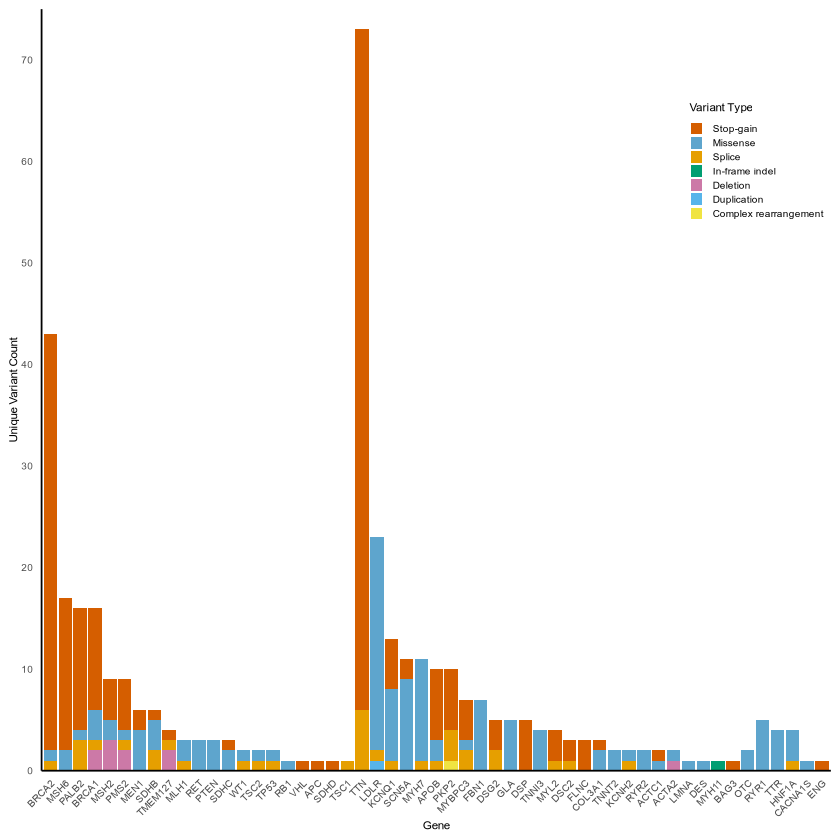

In [14]:
stacked_bar_chart <- ggplot(var_type_grouped, aes(x = Gene, y = Count, fill = Consequence_Class)) +
  geom_bar(stat = "identity") +
  labs(
    # title = "Variant types breakdown by genes",
    x = "Gene",
    y = "Unique Variant Count",
    fill = "Variant Type"
  ) +
  scale_y_continuous(
    breaks = seq(0, 75, by = 10),  # Set y-axis ticks at 5% intervals
    limits = c(0, 75), 
    expand = c(0, 0)  # Remove space at the bottom of the y-axis
  ) +
  # theme_minimal(base_family = "Arial") + 
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 6),  # Former x-axis text, now on y-axis
    axis.text.x = element_text(angle = 45, size = 6, hjust = 1),  # Former y-axis text, now on x-axis
    plot.title = element_blank(),
    axis.title.y = element_text(size = 7),  # Former x-axis title
    axis.title.x = element_text(size = 7),  # Former y-axis title
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"), 
    legend.title = element_text(size = 7),
    legend.text = element_text(size = 6),
    legend.key.size = unit(0.3, "cm"),  # Reduce legend key size
    legend.position.inside = c(.9, .8),  # Position the legend
    legend.position = "inside",
  ) +
  scale_fill_manual(
    values = c(
      "Stop-gain" = "#D55E00", 
      "Missense" = "#5EA5CD",
      "Splice" = "#E69F00",
      "In-frame indel" = "#019E72",
      "Deletion" = "#CC79A7",
      "Duplication" = "#57B4EA",
      "Complex rearrangement" = "#F0E442"
    )
  )

# Display the plot
stacked_bar_chart

# # Save the plot
# ggsave(
#   filename = "results/secondary/dominant/main/variant_types.pdf",
#   plot = stacked_bar_chart,
#   width = 168, height = 56, 
#   units = "mm", dpi = 600
# )

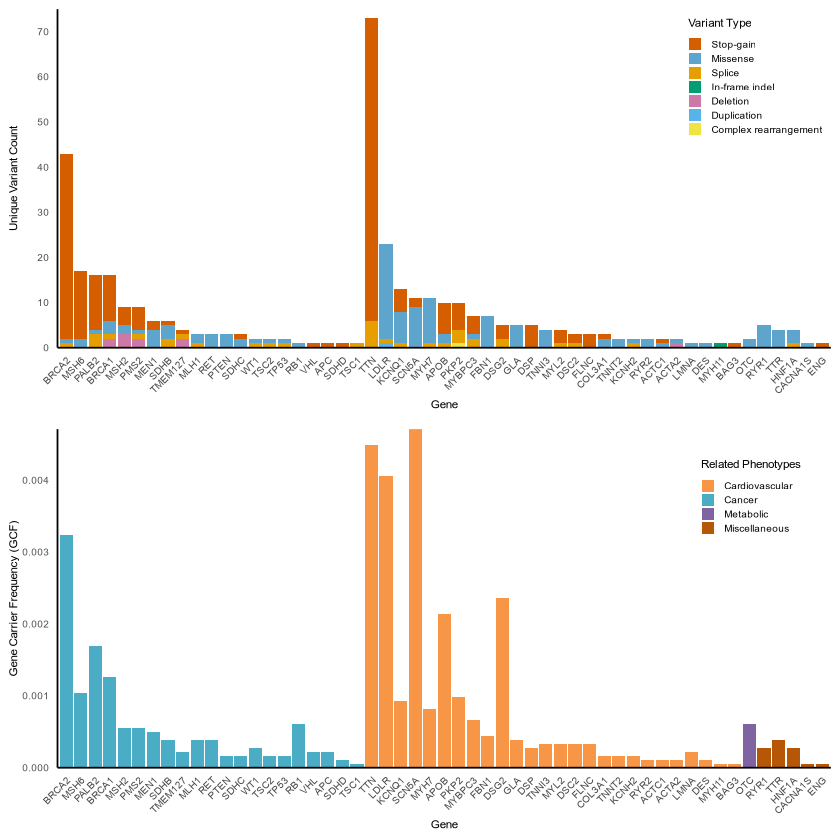

In [15]:
# Combine plots using cowplot
combined_plot <- plot_grid(
  stacked_bar_chart,
  p,
  ncol = 1,
  rel_heights = c(1, 1),
  align = "v"
)

# Display the combined plot
combined_plot


# ggsave(
# 	filename = "results/secondary/dominant/main/combined_variant_gcf.pdf",
# 	plot = combined_plot,
# 	width = 210, height = 112,
# 	units = "mm", dpi = 600
# )

## Zoom-in for enriched genes in Chinese

In [16]:
enriched_tsv <- "resources/chi_enriched_genes.tsv"
enriched_df <- read.csv(file = enriched_tsv, sep = "\t", header = TRUE, stringsAsFactors = FALSE)

# Sort enriched_df by "CHI_HKGI" in descending order
enriched_df <- enriched_df %>%
    arrange(desc(CHI_HKGI))

# Filter out "PKP2" from enriched_df
enriched_df <- enriched_df %>%
    filter(Gene != "PKP2")

In [17]:
# Reshape enriched_df to long format for plotting
enriched_long <- enriched_df %>%
  pivot_longer(
    cols = c(CHI_HKGI, KOR_Korea, EUR_Iceland, AFR_AoU),
    names_to = "Population",
    values_to = "Value"
  )

# Reverse the order of Gene based on the original order in enriched_df
enriched_long$Gene <- factor(enriched_long$Gene, levels = rev(c(
  "SCN5A", "LDLR", "DSG2", "APOB", "PKP2", "TTN"
)))

# Keep the order of Population
enriched_long$Population <- factor(
    enriched_long$Population, 
    levels = c("CHI_HKGI", "KOR_Korea", "EUR_Iceland", "AFR_AoU")
)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


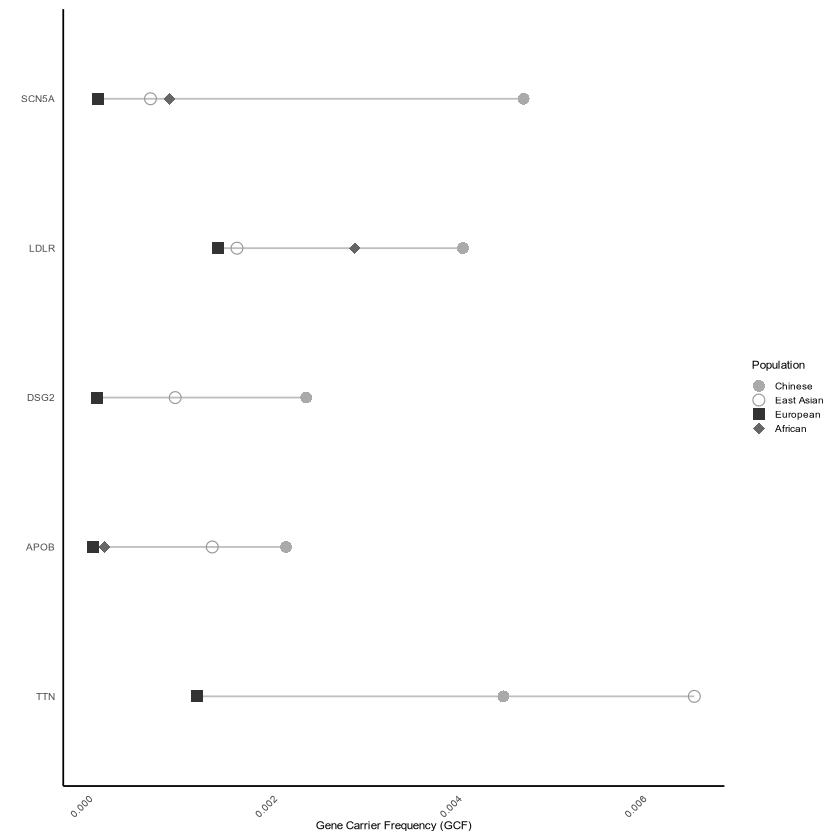

In [18]:
# Plot the dot plot with connecting lines and swapped axes
dot_line_plot <- ggplot(enriched_long, aes(x = Value, y = Gene, group = Gene, color = Population, shape = Population)) +
  geom_line(aes(group = Gene), color = "gray", size = 0.5) +  # Add connecting lines
  geom_point(size = 3) +  # Add dots
  labs(
    # title = "Significantly enriched genes in Chinese",
    x = "Gene Carrier Frequency (GCF)",
    y = "",
    color = "Population",
    shape = "Population"
  ) +
  # theme_minimal(base_family = "Arial") + 
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 6),
    axis.text.x = element_text(angle = 45, size = 6, hjust = 1),
    plot.title = element_blank(),
    axis.title.y = element_text(size = 7),
    axis.title.x = element_text(size = 7),
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"), 
    legend.title = element_text(size = 7),
    legend.text = element_text(size = 6),
    legend.key.size = unit(0.3, "cm")
  ) +
  scale_color_manual(
    labels = c(
      "CHI_HKGI" = "Chinese",
      "KOR_Korea" = "East Asian",
      "EUR_Iceland" = "European",
      "AFR_AoU" = "African"
    ),
    values = c(
      "CHI_HKGI" = "#AAAAAA",
      "KOR_Korea" = "#999999",
      "EUR_Iceland" = "#333333",
      "AFR_AoU" = "#666666"
    )
  ) +
  scale_shape_manual(
    labels = c(
      "CHI_HKGI" = "Chinese",
      "KOR_Korea" = "East Asian",
      "EUR_Iceland" = "European",
      "AFR_AoU" = "African"
    ),
    values = c(
      "CHI_HKGI" = 16,  # Filled circle
      "KOR_Korea" = 1,  # Filled triangle
      "EUR_Iceland" = 15,  # Filled square
      "AFR_AoU" = 18     # Filled diamond
    )
  )
  
# Display the plot
dot_line_plot

# # Save the plot
# ggsave(
#   filename = "results/secondary/dominant/main/chi_enriched_genes.pdf",
#   plot = dot_line_plot,
#     width = 90, height = 60, 
#     units = "mm", dpi = 600
# )

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_bar()`).”


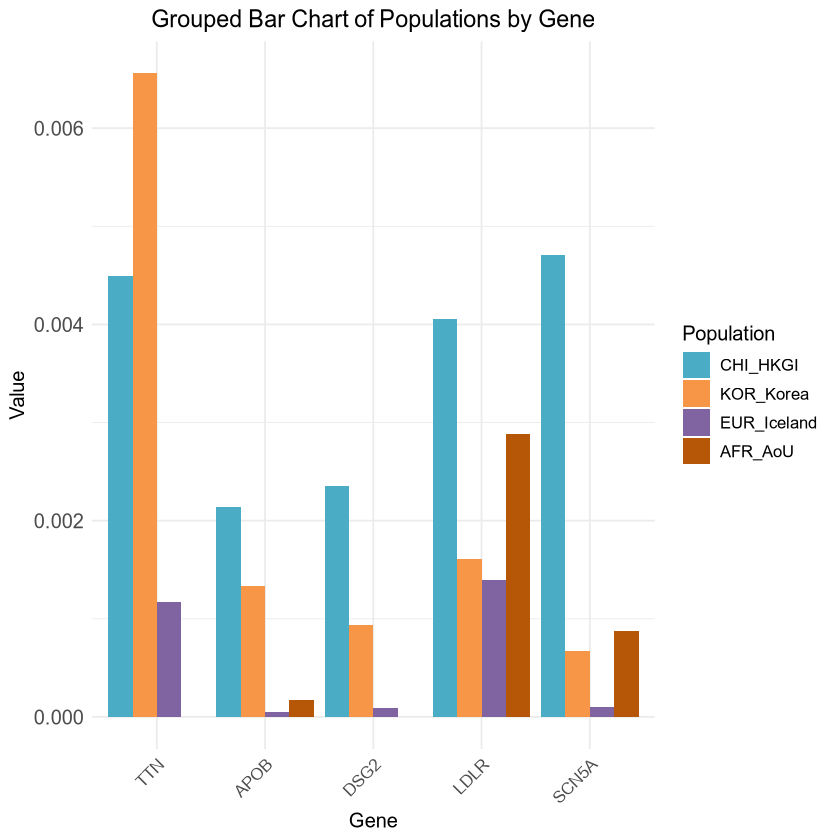

In [19]:
# Plot the grouped bar chart
grouped_bar_plot <- ggplot(enriched_long, aes(x = Gene, y = Value, fill = Population)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_minimal() +
  labs(
    title = "Grouped Bar Chart of Populations by Gene",
    x = "Gene",
    y = "Value",
    fill = "Population"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 12),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  ) +
  scale_fill_manual(
    values = c(
      "CHI_HKGI" = "#4BACC6",
      "KOR_Korea" = "#F79646",
      "EUR_Iceland" = "#8064A2",
      "AFR_AoU" = "#B65708"
    )
  )

# Display the plot
grouped_bar_plot